In [4]:
import sys
!$sys.executable -m pip install tensorflow ##Installing tensorflow

     |████████████████████████████████| 241.2 MB 91 kB/s s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 438 kB 36.7 MB/s eta 0:00:01
  Using cached libclang-14.0.6-py2.py3-none-macosx_10_9_x86_64.whl (13.2 MB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cached grpcio-1.50.0-cp38-cp38-macosx_10_10_x86_64.whl (4.5 MB)
     |████████████████████████████████| 5.9 MB 15.8 MB/s eta 0:00:01
  Using cached protobuf-3.19.6-cp38-cp38-macosx_10_9_x86_64.whl (980 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp38-cp38-macosx_10_14_x86_64.whl (1.6 MB)

In [1]:
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

In [2]:
tf.random.set_seed(9)

In [3]:
file = 'Nasdaqpredictive.csv'
raw_data = pd.read_csv(file, parse_dates = ['Date'], index_col = "Date")

df = raw_data.copy()
df = df.iloc[::-1]
df.head()

,ChangeNasdaq,save.Value,CPI,FederalFundsRate,X10YrTreasuryYield,CrudeOilPrice,FedReservesOnHand,EconomicPolicy,Index,ExpectedStockIncrease,InterestRates
Date,,,,,,,,,,,
2010-07-31,0.068963,6.4,217.923,0.16,3.42,20.74,995.183,1.727273,67.8,44.7,2.357143
2010-08-31,-0.062390,6.5,218.275,0.10,3.47,24.42,1003.206,1.808081,68.9,45.4,2.323232
2010-09-30,0.120429,6.5,219.035,0.09,3.32,26.27,1011.124,1.757576,68.2,45.2,2.222222
2010-10-31,0.058595,6.3,219.590,0.10,3.05,27.02,1027.089,1.656566,67.7,46.4,2.313131
2010-11-30,-0.003661,6.1,220.472,0.07,3.18,25.52,1078.051,1.690000,71.6,50.5,2.252525


<AxesSubplot:xlabel='Date'>

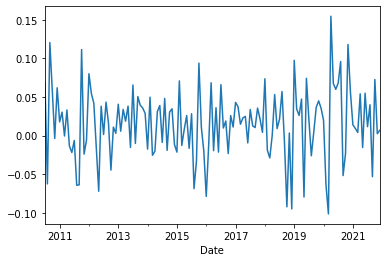

In [5]:
Nasdaq = df['ChangeNasdaq']
Nasdaq.plot()

In [50]:
def dfToXY(df, window_size=5):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(x), np.array(y)

In [54]:
x,y = dfToXY(df, 4)
x.shape, y.shape

((134, 4, 11), (134,))

In [8]:
x = np.squeeze(x) #getting rid of the third dimension (=value 1) from x array
x.shape

(134, 4, 11)

In [11]:
trainSize = int(len(df)*0.80)
valSize = int(len(df)*.05)
xTrain, yTrain = x[:trainSize], y[:trainSize]
xVal, yVal = x[trainSize:trainSize+valSize], y[trainSize:trainSize+valSize]
xTest, yTest = x[trainSize+valSize:], y[trainSize+valSize:]
xTrain.shape, yTrain.shape, xVal.shape,yVal.shape,xTest.shape, yTest.shape

((110, 4, 11), (110,), (6, 4, 11), (6,), (18, 4, 11), (18,))

In [12]:
NasdaqTrainMean = np.mean(xTrain[:, :, 0])
NasdaqTrainStd = np.std(xTrain[:, :, 0])

#print(BitTrainMean)
#print(BitTrainStd)                   

def preprocess(x):
    x[:, :, 0] = (x[:, :, 0] - NasdaqTrainMean) / NasdaqTrainStd
    return x

In [13]:
preprocess(xTrain)
preprocess(xVal)
preprocess(xTest)

array([[[-2.78504140e+00,  1.31000000e+01,  2.56094000e+02,
          9.00000000e-02,  8.80000000e-01,  8.64100000e+01,
          3.26814400e+03,  2.15151515e+00,  8.91000000e+01,
          5.76000000e+01,  1.97959184e+00],
        [ 3.45695698e+00,  3.38000000e+01,  2.55944000e+02,
          9.00000000e-02,  8.40000000e-01,  9.72100000e+01,
          2.91875600e+03,  2.00000000e+00,  7.18000000e+01,
          5.62000000e+01,  2.01010101e+00],
        [ 1.33461530e+00,  2.48000000e+01,  2.57217000e+02,
          9.00000000e-02,  9.30000000e-01,  9.85700000e+01,
          2.61527200e+03,  1.90625000e+00,  7.23000000e+01,
          5.39000000e+01,  2.02040816e+00],
        [ 1.14950843e+00,  1.93000000e+01,  2.58543000e+02,
          7.00000000e-02,  1.11000000e+00,  1.00240000e+02,
          2.81579400e+03,  1.86597938e+00,  7.81000000e+01,
          5.50000000e+01,  2.02040816e+00]],

       [[ 3.45695698e+00,  3.38000000e+01,  2.55944000e+02,
          9.00000000e-02,  8.40000000e-01,

In [15]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [19]:
model1 = Sequential()
model1.add(InputLayer((4, 11)))
model1.add(LSTM(100))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               44800     
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 45,617
Trainable params: 45,617
Non-trainable params: 0
_________________________________________________________________


In [20]:
cp = ModelCheckpoint("model1/", save_best_only = True, monitor = "loss")
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate = 0.0001), metrics=[RootMeanSquaredError()])

In [21]:
model1.fit(xTrain,yTrain,validation_data = (xVal,yVal),epochs = 10, callbacks =[cp])

Epoch 1/10
1/4 [======>.......................] - ETA: 7s - loss: 0.0761 - root_mean_squared_error: 0.2759

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 7s 2s/step - loss: 0.0646 - root_mean_squared_error: 0.2541 - val_loss: 0.0670 - val_root_mean_squared_error: 0.2587
Epoch 2/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.2120

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0401 - root_mean_squared_error: 0.2003 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1946
Epoch 3/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0326 - root_mean_squared_error: 0.1806

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1512
Epoch 4/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1187

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1232
Epoch 5/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0982

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 6/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0564

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 7/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0689

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 8/10
4/4 [==============================] - 0s 17ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859
Epoch 9/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 10/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0044 - root_mean_squared_error: 0.0661 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880


In [22]:
trainPredictions = model1.predict(xTrain).flatten()
trainResults = pd.DataFrame(
    data = {'Train Predictions':trainPredictions,
    "Actuals":yTrain})
trainResults

4/4 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,-0.044392,-0.003661
1,-0.021435,0.061900
2,0.067690,0.017796
3,0.100932,0.030440
4,0.103532,-0.000431
...,...,...
105,-0.049544,-0.025997
106,-0.048525,0.004579
107,-0.044627,0.036631
108,-0.039534,0.044994


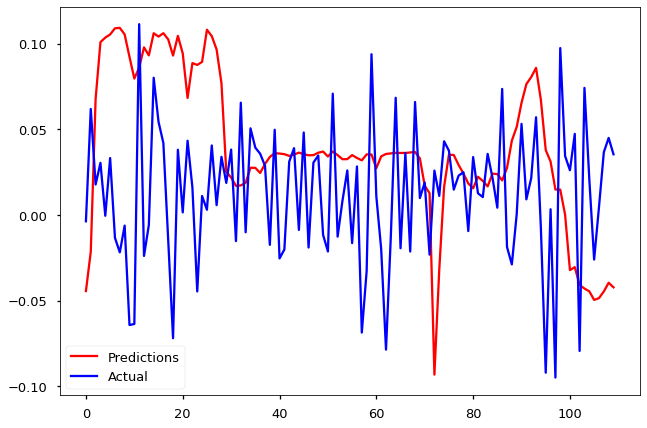

In [61]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
plt.plot(trainResults['Train Predictions'],"-r",label = "Predictions")
plt.plot(trainResults['Actuals'], "-b",label = "Actual Values")

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [24]:
testPredictions = model1.predict(xTest).flatten()
testResults = pd.DataFrame(
    data = {'Test Predictions':testPredictions,
    "Actuals":yTest})
testResults

1/1 [==============================] - 0s 28ms/step


,Test Predictions,Actuals
0,0.047451,0.068249
1,0.049810,0.095874
2,0.048530,-0.051629
3,0.048690,-0.022916
4,0.045029,0.117962
5,0.040232,0.056526
6,0.042128,0.014153
7,0.028216,0.009308
8,0.029282,0.004133
9,0.042773,0.054036


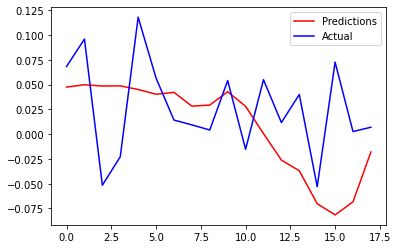

In [25]:
plt.plot(testResults['Test Predictions'], "-r")
plt.plot(testResults['Actuals'],"-b")


location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [26]:
rmse = np.sqrt(np.mean(testPredictions - yTest)**2)
rmse

0.01759637237813475

In [27]:
mae = np.mean(abs(testPredictions - yTest))
mae

0.049506779658592244

In [57]:
trainrmse = np.sqrt(np.mean(trainPredictions - yTrain)**2)
trainrmse

0.026006952703431913

In [58]:
trainmae = np.mean(abs(trainPredictions - yTrain))
trainmae

0.05298456533736727

In [29]:
model2 = Sequential()
model2.add(InputLayer((4, 11)))
model2.add(LSTM(100, activation='relu', return_sequences=True))
model2.add(LSTM(100, activation = 'relu', return_sequences = True))
model2.add(LSTM(100))
model2.add(Dropout(0.1))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 4, 100)            44800     
                                                                 
 lstm_4 (LSTM)               (None, 4, 100)            80400     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 205,701
Trainable params: 205,701
Non-trainable params: 0
_________________________________________________________________


In [30]:
cp2 = ModelCheckpoint("model2/", save_best_only = True, monitor = "loss")
model2.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate = 0.0001), metrics=[RootMeanSquaredError()])

In [31]:
model2.fit(xTrain,yTrain,epochs = 25, callbacks =[cp2])

Epoch 1/25
1/4 [======>.......................] - ETA: 12s - loss: 0.5308 - root_mean_squared_error: 0.7286

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 11s 2s/step - loss: 0.4152 - root_mean_squared_error: 0.6443
Epoch 2/25
1/4 [======>.......................] - ETA: 0s - loss: 0.2423 - root_mean_squared_error: 0.4922

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.1857 - root_mean_squared_error: 0.4310
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.1198 - root_mean_squared_error: 0.3462

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.1198 - root_mean_squared_error: 0.3462
Epoch 4/25
4/4 [==============================] - 0s 14ms/step - loss: 0.1297 - root_mean_squared_error: 0.3602
Epoch 5/25
1/4 [======>.......................] - ETA: 0s - loss: 0.0994 - root_mean_squared_error: 0.3152

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.0938 - root_mean_squared_error: 0.3063
Epoch 6/25
1/4 [======>.......................] - ETA: 0s - loss: 0.0555 - root_mean_squared_error: 0.2356

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.0722 - root_mean_squared_error: 0.2688
Epoch 7/25
4/4 [==============================] - ETA: 0s - loss: 0.0664 - root_mean_squared_error: 0.2576

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.0664 - root_mean_squared_error: 0.2576
Epoch 8/25
4/4 [==============================] - 0s 14ms/step - loss: 0.0717 - root_mean_squared_error: 0.2677
Epoch 9/25
4/4 [==============================] - 0s 12ms/step - loss: 0.0686 - root_mean_squared_error: 0.2619
Epoch 10/25
4/4 [==============================] - 0s 10ms/step - loss: 0.0839 - root_mean_squared_error: 0.2896
Epoch 11/25
4/4 [==============================] - 0s 12ms/step - loss: 0.0685 - root_mean_squared_error: 0.2616
Epoch 12/25
4/4 [==============================] - 0s 13ms/step - loss: 0.1190 - root_mean_squared_error: 0.3450
Epoch 13/25
4/4 [==============================] - 0s 10ms/step - loss: 0.0761 - root_mean_squared_error: 0.2759
Epoch 14/25
4/4 [==============================] - 0s 10ms/step - loss: 0.0843 - root_mean_squared_error: 0.2903
Epoch 15/25
1/4 [======>.......................] - ETA: 0s - loss: 0.0693 - root_mean_squared_error: 0.2632

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.0598 - root_mean_squared_error: 0.2446
Epoch 16/25
4/4 [==============================] - 0s 19ms/step - loss: 0.0599 - root_mean_squared_error: 0.2448
Epoch 17/25
4/4 [==============================] - 0s 12ms/step - loss: 0.0627 - root_mean_squared_error: 0.2504
Epoch 18/25
1/4 [======>.......................] - ETA: 0s - loss: 0.0573 - root_mean_squared_error: 0.2393

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.0576 - root_mean_squared_error: 0.2400
Epoch 19/25
4/4 [==============================] - 0s 19ms/step - loss: 0.0862 - root_mean_squared_error: 0.2935
Epoch 20/25
4/4 [==============================] - 0s 15ms/step - loss: 0.0746 - root_mean_squared_error: 0.2731
Epoch 21/25
4/4 [==============================] - 0s 16ms/step - loss: 0.0846 - root_mean_squared_error: 0.2908
Epoch 22/25
4/4 [==============================] - 0s 11ms/step - loss: 0.0638 - root_mean_squared_error: 0.2525
Epoch 23/25
4/4 [==============================] - 0s 10ms/step - loss: 0.0603 - root_mean_squared_error: 0.2455
Epoch 24/25
4/4 [==============================] - 0s 10ms/step - loss: 0.0584 - root_mean_squared_error: 0.2418
Epoch 25/25
4/4 [==============================] - 0s 10ms/step - loss: 0.0586 - root_mean_squared_error: 0.2420


In [32]:
trainPredictions2 = model2.predict(xTrain).flatten()
trainResults2 = pd.DataFrame(
    data = {'Train Predictions':trainPredictions2,
    "Actuals":yTrain})
trainResults2

4/4 [==============================] - 1s 4ms/step


,Train Predictions,Actuals
0,0.122463,-0.003661
1,0.070598,0.061900
2,-0.029583,0.017796
3,0.018347,0.030440
4,0.156031,-0.000431
...,...,...
105,0.099922,-0.025997
106,0.082142,0.004579
107,0.034459,0.036631
108,0.046108,0.044994


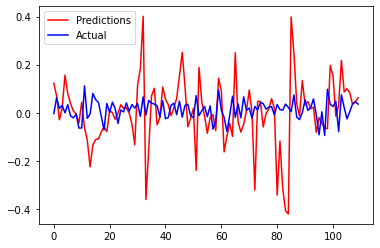

In [33]:
plt.plot(trainResults2['Train Predictions'],"-r",label = "Predictions")
plt.plot(trainResults2['Actuals'], "-b",label = "Actual Values")

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [34]:
testPredictions2 = model2.predict(xTest).flatten()
testResults2 = pd.DataFrame(
    data = {'Test Predictions':testPredictions2,
    "Actuals":yTest})
testResults2

1/1 [==============================] - 0s 27ms/step


,Test Predictions,Actuals
0,0.196489,0.068249
1,0.196212,0.095874
2,0.208468,-0.051629
3,0.173557,-0.022916
4,0.208487,0.117962
5,0.213991,0.056526
6,0.082037,0.014153
7,0.301864,0.009308
8,0.061219,0.004133
9,-0.241503,0.054036


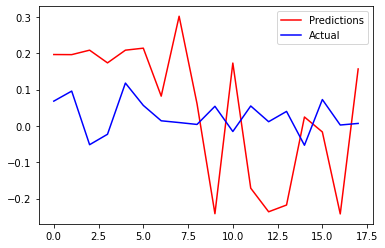

In [35]:
plt.plot(testResults2['Test Predictions'], "-r")
plt.plot(testResults2['Actuals'],"-b")


location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [38]:
rmse = np.sqrt(np.mean(testPredictions2 - yTest)**2)
rmse

0.022532296068683413

In [39]:
mae = np.mean(abs(testPredictions2 - yTest))
mae

0.17376166995478662

In [55]:
trainrmse = np.sqrt(np.mean(trainPredictions2 - yTrain)**2)
trainrmse

0.012644299337122938

In [56]:
trainmae = np.mean(abs(trainPredictions2 - yTrain))
trainmae

0.09892031633580284

In [46]:
from keras.models import load_model
    
model2.save('NasdaqModel2.h5')  # creates a HDF5 file 'my_model.h5'
model2 = load_model('NasdaqModel2.h5')# returns a compiled model identical to the previous one

In [40]:
raw_data = pd.read_csv(file,parse_dates = ["Date"], index_col = False)
df1 = raw_data.copy()

Dates = df1.iloc[::-1]
Dates = Dates["Date"]
Dates.head()

137   2010-07-31
136   2010-08-31
135   2010-09-30
134   2010-10-31
133   2010-11-30
Name: Date, dtype: datetime64[ns]

In [41]:
trainSize = int(len(Dates)*0.80)
valSize = int(len(Dates)*.05)

trainDates = Dates[:trainSize]
testDates = Dates[trainSize+valSize:]

In [42]:
trainDates = Dates[0:109]
testDates = Dates[120:138]

trainDates = trainDates.reset_index()
testDates = testDates.reset_index()

trainDates = trainDates.pop('Date')
testDates = testDates.pop('Date')

#trainDates
#testDates

In [43]:
trainResults2 = pd.concat([trainResults2,trainDates],axis=1)
testResults2 = pd.concat([testResults2,testDates],axis=1)

trainResults2 = trainResults2.set_index("Date")
testResults2 = testResults2.set_index("Date")


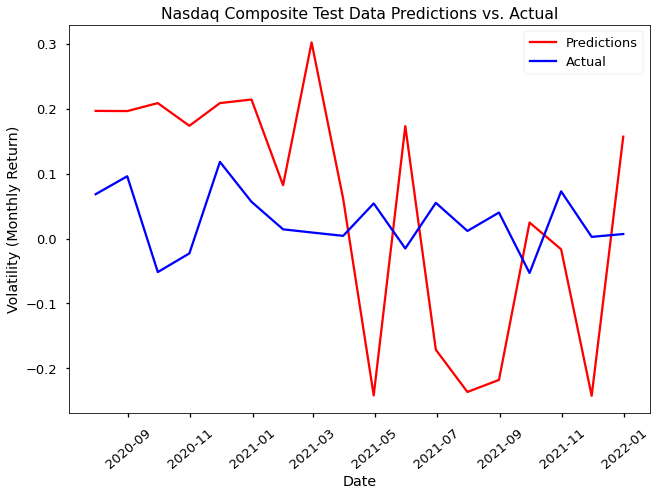

In [62]:
plt.plot(testResults2['Test Predictions'], "-r")
plt.plot(testResults2['Actuals'],"-b")
plt.xticks(rotation = 40) # 40 is the rotation angle
plt.title("Nasdaq Composite Test Data Predictions vs. Actual")
plt.xlabel('Date') 
plt.ylabel('Volatility (Monthly Return)') 
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

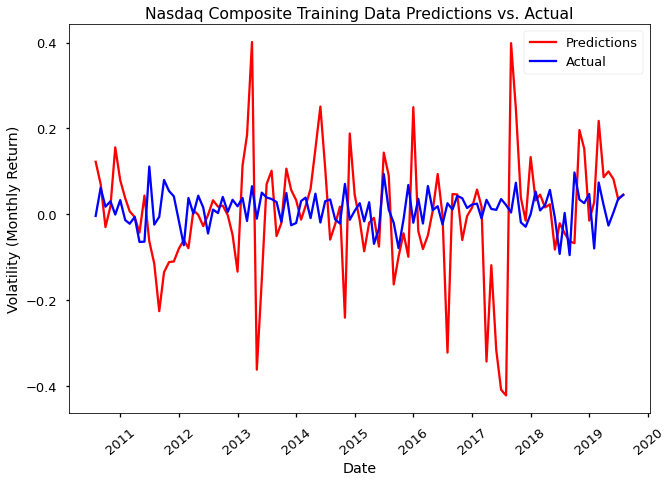

In [63]:
plt.plot(trainResults2['Train Predictions'], "-r")
plt.plot(trainResults2['Actuals'],"-b")
plt.xticks(rotation = 40) # 40 is the rotation angle
plt.title("Nasdaq Composite Training Data Predictions vs. Actual")
plt.xlabel('Date') 
plt.ylabel('Volatility (Monthly Return)') 
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [64]:
trainResults2.to_csv('NasdaqTrainResults.csv')
testResults2.to_csv('NasdaqTestResults.csv')